In [4]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, f1_score

GridSearchCV 수행 중...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

최적 파라미터: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 1000}
최고 CV 점수 (Macro F1): 0.7285

[Classification Report]
              precision    recall  f1-score   support

           0       0.75      0.45      0.56        20
           1       0.91      0.85      0.88        60
           2       0.86      0.95      0.90       120

    accuracy                           0.87       200
   macro avg       0.84      0.75      0.78       200
weighted avg       0.87      0.87      0.86       200



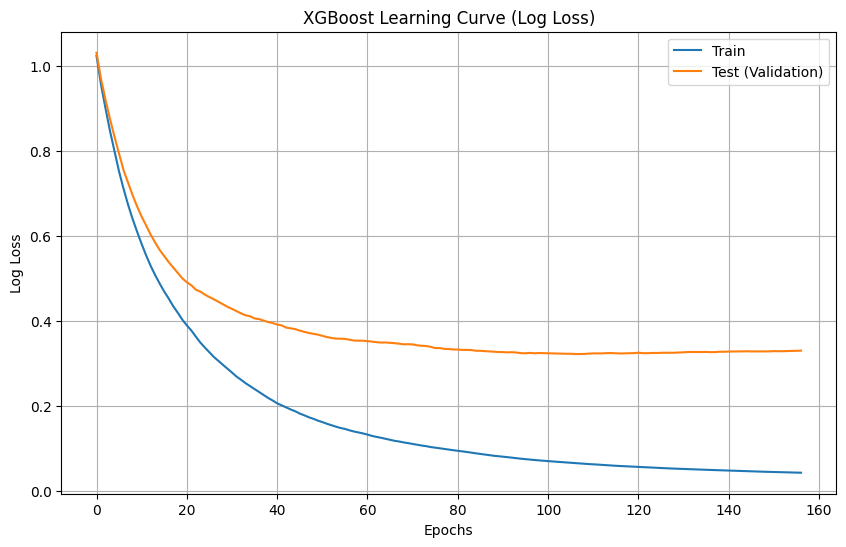

In [1]:
# ---------------------------------------------------------
# 1. 데이터 생성 (불균형한 다중 분류 데이터 예시)
# ---------------------------------------------------------
# 1000개의 샘플, 3개의 클래스, 불균형 비율 설정
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10,
                           n_classes=3, weights=[0.1, 0.3, 0.6], random_state=42)

# 학습/테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ---------------------------------------------------------
# 2. 클래스 불균형 처리 (Sample Weight 계산)
# ---------------------------------------------------------
# 다중 분류에서는 scale_pos_weight 대신 각 샘플에 가중치를 부여합니다.
# 희소한 클래스일수록 높은 가중치를 갖게 됩니다.
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

# ---------------------------------------------------------
# 3. 모델 및 GridSearchCV 설정
# ---------------------------------------------------------
# XGBClassifier 초기화
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob', # 다중 분류 확률
    num_class=3,                # 클래스 개수
    tree_method='hist',         # 속도 및 범주형 변수 처리에 유리
    device='cpu',               # GPU 사용 시 'cuda'
    enable_categorical=True,    # 범주형 데이터 지원 (필요 시)
    eval_metric='mlogloss',
    early_stopping_rounds = 50,# 다중 분류 평가 지표
    random_state=42
)

# 튜닝할 파라미터 그리드
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5], # 결측/노이즈가 많을 때 중요
    'n_estimators': [1000]         # Early Stopping을 위해 충분히 크게 설정
}

# GridSearchCV 설정
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_macro', # 불균형 데이터이므로 Macro F1 사용 권장
    cv=3,
    verbose=1,
    n_jobs=-1
)

# ---------------------------------------------------------
# 4. 학습 실행 (Early Stopping 포함)
# ---------------------------------------------------------
print("GridSearchCV 수행 중...")

# fit 파라미터에 early_stopping 관련 설정 주입
fit_params = {
    'eval_set': [(X_train, y_train), (X_test, y_test)], # 학습 곡선을 위해 Train/Test 모두 전달
    'sample_weight': sample_weights, # [중요] 불균형 처리를 위한 가중치 적용
    'verbose': False
}

grid_search.fit(X_train, y_train, **fit_params)

# 최적의 모델 추출
best_model = grid_search.best_estimator_

print(f"\n최적 파라미터: {grid_search.best_params_}")
print(f"최고 CV 점수 (Macro F1): {grid_search.best_score_:.4f}")

# ---------------------------------------------------------
# 5. 최종 평가
# ---------------------------------------------------------
y_pred = best_model.predict(X_test)
print("\n[Classification Report]")
print(classification_report(y_test, y_pred))

# ---------------------------------------------------------
# 6. 학습 곡선 (Learning Curve) 시각화
# ---------------------------------------------------------
results = best_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(figsize=(10, 6))

# Log Loss 차트
ax.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
ax.plot(x_axis, results['validation_1']['mlogloss'], label='Test (Validation)')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curve (Log Loss)')
plt.grid(True)
plt.show()

>>> 데이터 준비 완료
결측치 개수: 6000
데이터 타입 확인:
feature_11     float64
feature_12    category
feature_13    category
feature_14    category
dtype: object
--------------------------------------------------
>>> 클래스별 부여된 가중치 예시:
Class 0: 20.0
Class 1: 3.0
Class 2: 1.0
--------------------------------------------------
>>> GridSearchCV 학습 시작...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

>>> 최적 파라미터: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 1000, 'reg_alpha': 5.0}
>>> 최고 CV 점수 (Macro F1): 0.6186

Classification Report
              precision    recall  f1-score   support

           0       0.46      0.29      0.35        21
           1       0.73      0.74      0.73        61
           2       0.92      0.94      0.93       318

    accuracy                           0.88       400
   macro avg       0.70      0.66      0.67       400
weighted avg       0.87      0.88      0.87       400



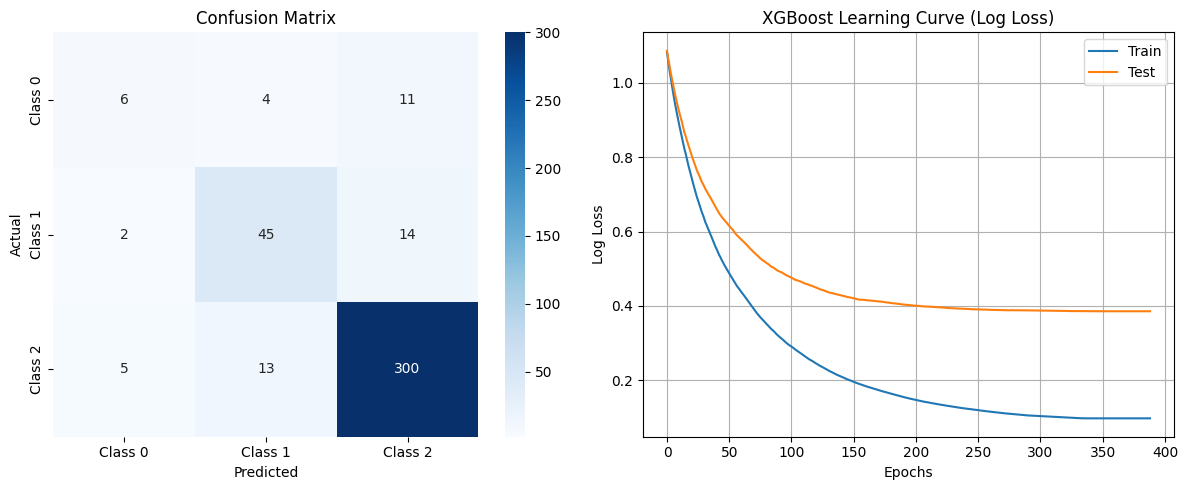

In [5]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix

# =============================================================================
# 1. 데이터 생성 (가상의 "지저분한" 데이터 만들기)
# =============================================================================
# 2000개의 샘플, 심각한 불균형 (Class 0: 5%, Class 1: 15%, Class 2: 80%)
X, y = make_classification(n_samples=2000, n_features=15, n_informative=10,
                           n_classes=3, weights=[0.05, 0.15, 0.8], random_state=42)

# DataFrame 변환
feature_names = [f"feature_{i}" for i in range(X.shape[1])]
df_X = pd.DataFrame(X, columns=feature_names)
df_y = pd.Series(y)

# [시나리오 적용] 1. 결측치(NaN) 강제 주입 (전체 데이터의 20%)
for col in df_X.columns:
    df_X.loc[df_X.sample(frac=0.2).index, col] = np.nan

# [시나리오 적용] 2. 범주형 변수 변환 (마지막 3개 컬럼을 범주형으로 가정)
cat_cols = feature_names[-3:]
for col in cat_cols:
    # 임의로 구간을 나누어 범주화 (예: 'A', 'B', 'C')
    df_X[col] = pd.cut(df_X[col], bins=3, labels=['A', 'B', 'C'])
    # ★ 중요: XGBoost Native Support를 위해 'category' 타입으로 변환
    df_X[col] = df_X[col].astype("category")

print(">>> 데이터 준비 완료")
print(f"결측치 개수: {df_X.isna().sum().sum()}")
print(f"데이터 타입 확인:\n{df_X.dtypes.tail(4)}")
print("-" * 50)

# 학습/검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42, stratify=df_y)

# =============================================================================
# 2. 강력한 클래스 가중치 (Sample Weight) 생성
# =============================================================================
# Class 0(5%)을 놓치지 않기 위해 가중치를 아주 강하게 설정
# 기본 balanced 가중치보다 Class 0에 더 가산점을 줌
custom_class_weights = {
    0: 20.0,  # 소수 클래스 (매우 중요)
    1: 3.0,   # 중간 클래스
    2: 1.0    # 다수 클래스
}

# 설정한 비율대로 각 샘플마다 가중치 부여
train_sample_weights = compute_sample_weight(
    class_weight=custom_class_weights,
    y=y_train
)

print(">>> 클래스별 부여된 가중치 예시:")
for c in [0, 1, 2]:
    idx = np.where(y_train == c)[0][0]
    print(f"Class {c}: {train_sample_weights[idx]:.1f}")
print("-" * 50)

# =============================================================================
# 3. 모델 및 GridSearchCV 설정
# =============================================================================
xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    tree_method='hist',       # [핵심] 결측치/범주형 처리에 필수
    enable_categorical=True,  # [핵심] 범주형 변수 자동 처리
    device='cpu',
    eval_metric='mlogloss',
    early_stopping_rounds = 50,
    seed=42
)

# 결측치가 많고 노이즈가 많은 데이터에 맞춘 파라미터 그리드
param_grid = {
    'n_estimators': [1000],          # Early Stopping용 (충분히 크게)
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],             # 깊이를 제한하여 과적합 방지
    'min_child_weight': [5, 10],     # [핵심] 결측치 노이즈 방지를 위해 높게 설정
    'colsample_bytree': [0.7],       # 변수 샘플링
    'reg_alpha': [1.0, 5.0]          # [핵심] L1 정규화로 불필요한 변수 제거 효과
}


sfk = StratifiedKFold(n_splits=3,shuffle=True,random_state=42
                      )
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='f1_macro',              # 불균형 데이터이므로 Macro F1 사용
    cv=sfk,
    verbose=1,
    n_jobs=-1
)

# =============================================================================
# 4. 학습 실행 (Early Stopping 포함)
# =============================================================================
# fit_params에 sample_weight와 eval_set을 모두 전달
fit_params = {
    'eval_set': [(X_train, y_train), (X_test, y_test)],
    'sample_weight': train_sample_weights, # ★ 가중치 적용
    'verbose': False
}

print(">>> GridSearchCV 학습 시작...")
grid_search.fit(X_train, y_train, **fit_params)

best_model = grid_search.best_estimator_
print(f"\n>>> 최적 파라미터: {grid_search.best_params_}")
print(f">>> 최고 CV 점수 (Macro F1): {grid_search.best_score_:.4f}")

# =============================================================================
# 5. 최종 평가 및 시각화
# =============================================================================
# 예측
y_pred = best_model.predict(X_test)

# [결과 1] Classification Report
print("\n" + "="*50)
print("Classification Report")
print("="*50)
print(classification_report(y_test, y_pred))

# [결과 2] Confusion Matrix 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# [결과 3] 학습 곡선 (Learning Curve) 시각화
results = best_model.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.subplot(1, 2, 2)
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Test')
plt.legend()
plt.ylabel('Log Loss')
plt.xlabel('Epochs')
plt.title('XGBoost Learning Curve (Log Loss)')
plt.grid(True)

plt.tight_layout()
plt.show()

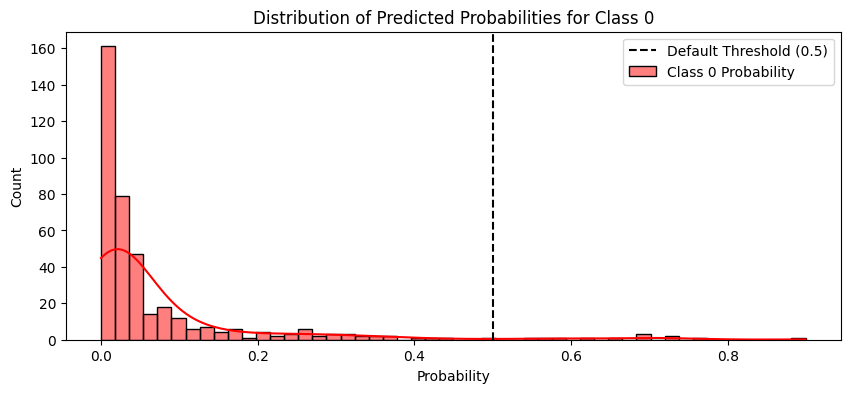


>>> [비교] 임계값 조정 결과
적용된 임계값: Class 0 >= 0.4, Class 1 >= 0.4

1. 기존 모델 (argmax 기준)
              precision    recall  f1-score   support

           0       0.46      0.29      0.35        21
           1       0.73      0.74      0.73        61
           2       0.92      0.94      0.93       318

    accuracy                           0.88       400
   macro avg       0.70      0.66      0.67       400
weighted avg       0.87      0.88      0.87       400

--------------------------------------------------

2. 임계값 조정 모델 (Custom Thresholds)
              precision    recall  f1-score   support

           0       0.44      0.33      0.38        21
           1       0.73      0.75      0.74        61
           2       0.93      0.94      0.94       318

    accuracy                           0.88       400
   macro avg       0.70      0.68      0.69       400
weighted avg       0.87      0.88      0.88       400


[Check] Class 0 예측 개수 변화: 13개 -> 16개


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report

# =============================================================================
# 6. 임계값(Threshold) 튜닝을 위한 확률값 추출
# =============================================================================
# 모델이 예측한 확률값 전체를 가져옵니다. (행: 샘플 수, 열: [Class0확률, Class1확률, Class2확률])
y_proba = best_model.predict_proba(X_test)

# 시각화: Class 0 (가장 중요한 소수 클래스)의 예측 확률 분포 확인
# 이 그래프를 보면 "몇 점 이상일 때 Class 0으로 쳐줄지" 결정하기 쉽습니다.
plt.figure(figsize=(10, 4))
sns.histplot(y_proba[:, 0], bins=50, kde=True, color='red', label='Class 0 Probability')
plt.axvline(x=0.5, color='black', linestyle='--', label='Default Threshold (0.5)')
plt.title("Distribution of Predicted Probabilities for Class 0")
plt.xlabel("Probability")
plt.ylabel("Count")
plt.legend()
plt.show()

# =============================================================================
# 7. 사용자 정의 임계값 적용 함수
# =============================================================================
def apply_custom_thresholds(proba, thresholds):
    """
    proba: 모델이 예측한 확률 배열 (N x 3)
    thresholds: 클래스별 임계값 딕셔너리 예: {0: 0.3, 1: 0.4}

    로직:
    1. Class 0 확률이 thresholds[0] 넘으면 -> Class 0
    2. 안 넘고, Class 1 확률이 thresholds[1] 넘으면 -> Class 1
    3. 둘 다 아니면 -> Class 2 (Majority)
    """
    final_preds = []

    # 임계값 설정 (기본값은 0.5로 설정하지만 아래에서 덮어씀)
    th_0 = thresholds.get(0, 0.5)
    th_1 = thresholds.get(1, 0.5)

    for p in proba:
        prob_0, prob_1, prob_2 = p

        if prob_0 >= th_0:   # 1순위: 소수 클래스 체크
            final_preds.append(0)
        elif prob_1 >= th_1: # 2순위: 중간 클래스 체크
            final_preds.append(1)
        else:                # 3순위: 나머지
            final_preds.append(2)

    return np.array(final_preds)

# =============================================================================
# 8. 임계값 적용 전후 비교
# =============================================================================

# [설정] 여기서 임계값을 조절하세요!
# 원래는 0.5(또는 1등)가 되어야 뽑히지만,
# Class 0은 30%(0.3)만 확신해도 정답으로 인정하겠다는 뜻
custom_thresholds = {
    0: 0.4,  # Class 0 임계값 (낮출수록 Class 0 예측(Recall) 증가, Precision 감소)
    1: 0.4   # Class 1 임계값
}

# 새로운 예측값 생성
y_pred_custom = apply_custom_thresholds(y_proba, custom_thresholds)

print("\n" + "="*50)
print(">>> [비교] 임계값 조정 결과")
print(f"적용된 임계값: Class 0 >= {custom_thresholds[0]}, Class 1 >= {custom_thresholds[1]}")
print("="*50)

print("\n1. 기존 모델 (argmax 기준)")
print(classification_report(y_test, y_pred)) # 기존 y_pred 사용

print("-" * 50)

print("\n2. 임계값 조정 모델 (Custom Thresholds)")
print(classification_report(y_test, y_pred_custom))

# 검증: 실제로 Class 0으로 예측된 개수가 늘었는지 확인
count_org = np.sum(y_pred == 0)
count_new = np.sum(y_pred_custom == 0)
print(f"\n[Check] Class 0 예측 개수 변화: {count_org}개 -> {count_new}개")